In [9]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
    
from datetime import datetime
import time

In [10]:
class ResolventFormalizm:
    
    def __init__(self, V_0, R, M):
        self.v_0 = v_0
        self.R = R
        self.M = M
        
        self.x = np.linspace(-R, R, M+1)
        self.delta = self.x[1] - self.x[0]
        
        # matrices
        diag_T = 2/self.delta**2
        subdiag_T = -1/self.delta**2 * np.ones(M-2)

        diag_V = self.v_0*np.exp(-self.x[1:-1]**2)

        diags_T = [subdiag_T, diag_T, subdiag_T]
        self.T = scipy.sparse.diags(diags_T,[-1,0,1]).toarray()

        diags_V = [diag_V]
        self.V = scipy.sparse.diags(diags_V,[0]).toarray()
    
    def R_mat(self, z):
        return scipy.linalg.inv(self.T - z * scipy.sparse.eye(self.M-1).toarray())
    
    def L_mat(self, z):
        return - self.R_mat(z) @ self.V
    
    def power_iteration(self, z, precision = 1e-4):
        L = self.L_mat(z)
        
        eigval = 0.0
        eigfun = np.exp(-self.x[1:-1]**2) / scipy.linalg.norm(np.exp(-self.x[1:-1]**2))
        
        while scipy.linalg.norm(L @ eigfun - eigval * eigfun) > precision:
            eigfun_2 = L @ eigfun
        
            eigfun = eigfun_2 / scipy.linalg.norm(eigfun_2)
        
            eigval = np.dot(eigfun_2, eigfun)
        
        return eigval
    
    def E_0_power_iteration(self, N):
        z = np.linspace(rf.v_0, 0.0, N)
        lambda_0 = np.full(len(z), np.nan)
        
        print(f"Ground state search has been started")
        
        for i in range(len(z)):
            if (i+1) % 10 == 0:
                print(f"{i+1:>5d} / {N:>5d}")
            lambda_0[i] = rf.power_iteration(z[i])
        
        lambda_0_cs = scipy.interpolate.CubicSpline(z, lambda_0)

        sol = scipy.optimize.root_scalar(lambda x: lambda_0_cs(x) - 1.0, bracket=[self.v_0, 0.0], method='brentq')
        
        return sol.root, z, lambda_0
    
    
    def arnoldi_iteration(self, A, b, n: int):
        """Computes a basis of the (n + 1)-Krylov subspace of A: the space
        spanned by {b, Ab, ..., A^n b}.
    
        Arguments
          A: m × m array
          b: initial vector (length m)
          n: dimension of Krylov subspace, must be >= 1
        
        Returns
          Q: m x (n + 1) array, the columns are an orthonormal basis of the
            Krylov subspace.
          h: (n + 1) x n array, A on basis Q. It is upper Hessenberg.  
        """
        eps = 1e-12
        h = np.zeros((n+1,n))
        Q = np.zeros((A.shape[0],n+1))
         # Normalize the input vector
        Q[:,0] =b/np.linalg.norm(b,2)   # Use it as the first Krylov vector
        for k in range(1,n+1):
            v = np.dot(A,Q[:,k-1])  # Generate a new candidate vector
            for j in range(k):  # Subtract the projections on previous vectors
                h[j,k-1] = np.dot(Q[:,j].T, v)
                v = v - h[j,k-1] * Q[:,j]
            h[k,k-1] = np.linalg.norm(v,2)
            if h[k,k-1] > eps:  # Add the produced vector to the list, unless
                Q[:,k] = v/h[k,k-1]
            else:  # If that happens, stop iterating.
                return Q, h
        return Q, h

    def lambda_z(self, z, n: int):
        Q, h = self.arnoldi_iteration(self.L_mat(z), np.random.rand(len(self.x[1:-1])), n=n)
        return np.real(scipy.linalg.eigvals(h[:-1]))
    
    def many_E_arnoldi_iterantion(self, n_branches=200, n_z=100):
        z = np.linspace(self.v_0, 0.0, n_z)
        lambda_ = np.full((n_branches, len(z)), np.nan)
        
        print(f"Many states search has been started")
        
        for i in range(len(z)):
            if (i+1) % 10 == 0:
                print(f"{i+1:>5d} / {n_z:>5d}")
            lambda_[:,i] = self.lambda_z(z[i], n_branches)
        
        for i in range(5):
            lambda_cs = scipy.interpolate.CubicSpline(z, lambda_[i])
            
            if (lambda_cs(self.v_0)<1) and (lambda_cs(0.0)>1):
                sol = scipy.optimize.root_scalar(lambda x: lambda_cs(x) - 1.0,
                                                 bracket=[self.v_0, 0.0], method='brentq')
                print(f"E_{i} = {sol.root:0.4f}")
                plt.axvline(x=sol.root, linewidth=1,
                            color=f'C{i+5}', linestyle=':',
                            label=fr'$E_{i} = {sol.root:>0.4f}$')
                
            plt.plot(z, lambda_[i], linewidth=1, label=fr'$\lambda_{i}(z)$')
    
                
        plt.axhline(y=1, linestyle='--', color='black', linewidth=2)


        plt.legend()
        plt.xlim(v_0,0.0)
        plt.ylim(0.0,5)
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\lambda(z)$')
        plt.title(fr'$V_0 = {v_0:>0.2f}$')
        
        plt.show()

#         plt.savefig(f'figures/{self.v_0}_l{5}.png', dpi=250)
        
        return lambda_

# Power iteration and ground state

In [11]:
# constants
v_0 = -5.0
R = 6.0
M = 1000

rf = ResolventFormalizm(v_0, R, M)

E_0, z_0, lambda_0 = rf.E_0_power_iteration(N=100)

print(f"E_0 = {E_0:0.4f}")

Ground state search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1406


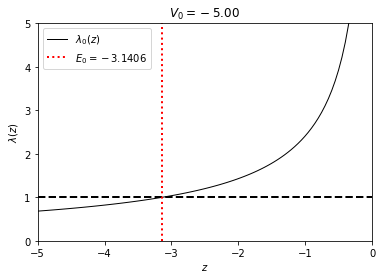

In [30]:
plt.plot(z_0, lambda_0, color='black', linewidth=1, label=r'$\lambda_0(z)$')
plt.axhline(y=1, linestyle='--', color='black', linewidth=2)
plt.axvline(x=E_0, linewidth=2, linestyle=':', color='red', label=fr'$E_0 = {E_0:>0.4f}$')

plt.legend()
plt.xlim(v_0,0.0)
plt.ylim(0.0,5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\lambda(z)$')
plt.title(fr'$V_0 = {v_0:>0.2f}$')

plt.savefig(f'figures/{rf.v_0}_l0.png', dpi=250)

# Arnoldi iteration and many states

In [5]:
rf = ResolventFormalizm(v_0, R, M)

Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1404
E_1 = -0.4042


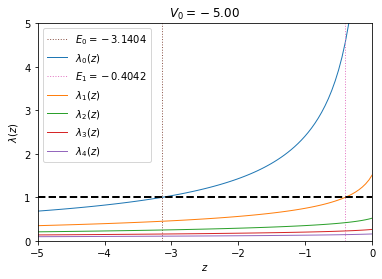

<Figure size 432x288 with 0 Axes>

In [6]:
lambda_ = rf.many_E_arnoldi_iterantion(n_branches=100, n_z=100)

# How much time does it take?

In [52]:
# Power itaration
v_0 = -5.0
R = 6.0
m = np.linspace(100, 1500, 25, dtype=int)
t = [None] * len(m)

for i in range(len(m)):
    start_time = datetime.now()
    
    rf = ResolventFormalizm(v_0, R, m[i])
    a, b, c = rf.E_0_power_iteration(N=100)
    
    t[i] = datetime.now() - start_time
    
    print('m=', m[i], ', t=', t[i])   

Ground state search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
m= 100 , t= 0:00:01.165454
Ground state search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
m= 158 , t= 0:00:04.281006
Ground state search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
m= 216 , t= 0:00:03.397923
Ground state search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
m= 275 , t= 0:00:03.694642
Ground state search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
m= 333 

In [8]:
tt = [t_.seconds+t_.microseconds*1e-6 for t_ in t]

p = np.poly1d(np.polyfit(m, tt, 2))
mm = np.linspace(m[0], m[-1])

plt.plot(m, tt, color='black', linewidth=1, label='Experimental results')

plt.plot(mm, p(mm), color='red', linewidth=1, linestyle='--', label=r'$O(M^2)$')

plt.xlabel(r'$M$', fontsize=14)
plt.ylabel('T, sec', fontsize=14)

plt.title(fr'$V_0={rf.v_0:},\; R={int(rf.R)}$', fontsize=14)

plt.xlim(m[0], m[-1])
plt.ylim(0, None)

plt.grid(alpha=0.5)
plt.legend()

plt.savefig(f'figures/T_vs_M_{rf.v_0}_l0.png', dpi=250)

NameError: name 't' is not defined

Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_1 = -3.1427
E_2 = -0.4080


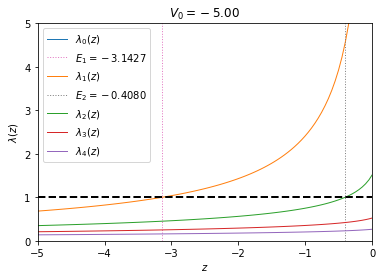

m= 100 , t= 0:00:16.042754
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1407
E_1 = -0.4048


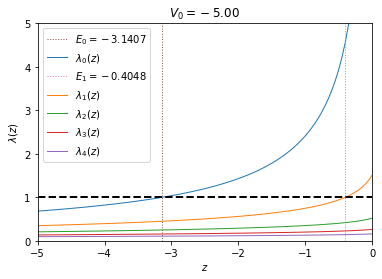

m= 255 , t= 0:00:24.733929
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1405
E_1 = -0.4044


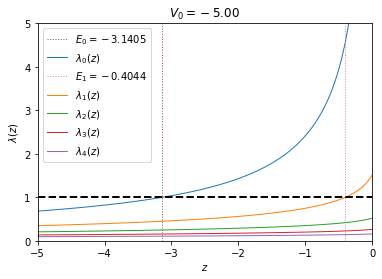

m= 411 , t= 0:00:30.331807
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1404
E_1 = -0.4043


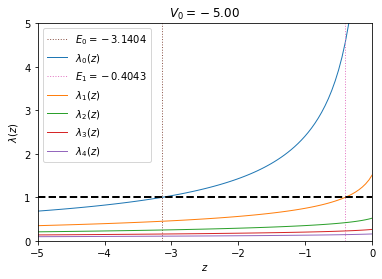

m= 566 , t= 0:00:39.848605
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1404
E_1 = -0.4042


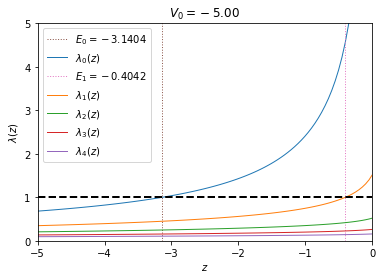

m= 722 , t= 0:00:51.967654
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1404
E_1 = -0.4042


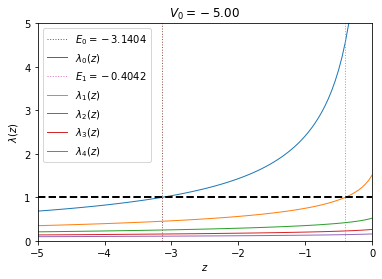

m= 877 , t= 0:01:02.918269
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1404
E_1 = -0.4042


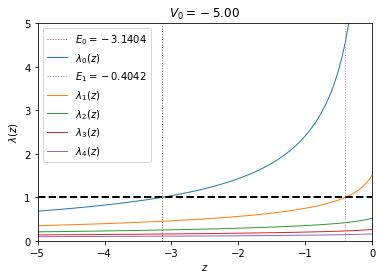

m= 1033 , t= 0:01:24.570826
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1404
E_1 = -0.4042


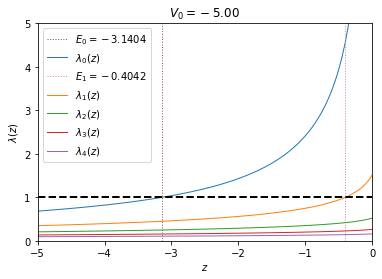

m= 1188 , t= 0:01:58.825550
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1403
E_1 = -0.4042


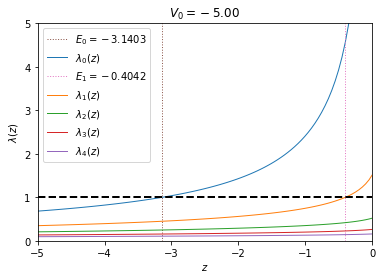

m= 1344 , t= 0:02:18.903977
Many states search has been started
   10 /   100
   20 /   100
   30 /   100
   40 /   100
   50 /   100
   60 /   100
   70 /   100
   80 /   100
   90 /   100
  100 /   100
E_0 = -3.1403
E_1 = -0.4042


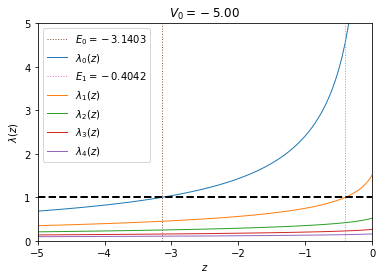

m= 1500 , t= 0:02:49.852000


<Figure size 432x288 with 0 Axes>

In [61]:
# Power itaration
v_0 = -5.0
R = 6.0
m = np.linspace(100, 1500, 10, dtype=int)
t = [None] * len(m)

for i in range(len(m)):
    start_time = datetime.now()
    
    rf = ResolventFormalizm(v_0, R, m[i])
    lambda_ = rf.many_E_arnoldi_iterantion(n_branches=10, n_z=100)
    
    t[i] = datetime.now() - start_time
    
    print('m=', m[i], ', t=', t[i])  

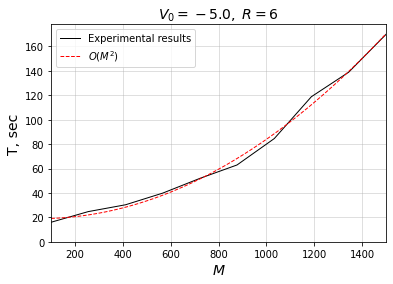

In [65]:
tt = [t_.seconds+t_.microseconds*1e-6 for t_ in t]

p = np.poly1d(np.polyfit(m, tt, 2))
mm = np.linspace(m[0], m[-1])

plt.plot(m, tt, color='black', linewidth=1, label='Experimental results')

plt.plot(mm, p(mm), color='red', linewidth=1, linestyle='--', label=r'$O(M^2)$')

plt.xlabel(r'$M$', fontsize=14)
plt.ylabel('T, sec', fontsize=14)

plt.title(fr'$V_0={rf.v_0:},\; R={int(rf.R)}$', fontsize=14)

plt.xlim(m[0], m[-1])
plt.ylim(0, None)

plt.grid(alpha=0.5)
plt.legend()

plt.savefig(f'figures/T_vs_M_{rf.v_0}_l5.png', dpi=250)